「ライブラリのインポート
データの読み込み、別れている場合は前処理の前に結合
データの確認
データの可視化
欠損値、異常値の処理
データ型変換・ダミー化(回帰分析の場合)」
↑ここまではExcelでOK

モデルの学習方法の選択

In [624]:
#ライブラリのインポートimport
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [625]:
#データの読み込みpd.read_
df_train = pd.read_csv("train.tsv", sep="\t")
df_test = pd.read_csv("test.tsv", sep="\t")

In [626]:
#前処理の前に結合pd.concat
df_train["ds_test"]=0
df_test["ds_test"]=1
df_all=pd.concat([df_train, df_test], axis=0)
df_all.head()

,id,survived,pclass,sex,age,sibsp,parch,fare,embarked,ds_test
0,3,1.0,1,female,35.0,1,0,53.1000,S,0
1,4,0.0,3,male,35.0,0,0,8.0500,S,0
2,7,0.0,3,male,2.0,3,1,21.0750,S,0
3,9,1.0,2,female,14.0,1,0,30.0708,C,0
4,11,1.0,1,female,58.0,0,0,26.5500,S,0


In [627]:
#データの確認1.describe
"""
countをidと比較して欠損値を確認
minとmax を確認し、値が常識的な範囲内かチェックします。
std（標準偏差）が極端に大きい場合、データに異常値（外れ値）が含まれている可能性があります。
mean(平均値)と50%(中央値)を比較データ分布の偏りを確認
四分位範囲（IQR）を使った異常値検出
25%と75%（四分位数）を使ってデータ範囲を確認します。
場合によってはIQR（第3四分位 - 第1四分位）を基に、範囲外の値を異常値と見なせます。
"""
df_all.describe()


,id,survived,pclass,age,sibsp,parch,fare,ds_test
count,891.000000,445.000000,891.000000,714.000000,891.000000,891.000000,891.000000,891.000000
mean,445.000000,0.402247,2.308642,29.699118,0.523008,0.381594,32.204208,0.500561
std,257.353842,0.490903,0.836071,14.526497,1.102743,0.806057,49.693429,0.500281
min,0.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000
25%,222.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400,0.000000
50%,445.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,1.000000
75%,667.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000,1.000000
max,890.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,1.000000


In [628]:
#データの確認2.info
"""
Index: データの行数 と Nou-Null Count:非欠損値の数
を比較して欠損値の数を確認できる。あれば欠損値を処理
dtypes:をみてobject型があればダミー化を検討
"""
df_all.info()


<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 0 to 445
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        891 non-null    int64  
 1   survived  445 non-null    float64
 2   pclass    891 non-null    int64  
 3   sex       891 non-null    object 
 4   age       714 non-null    float64
 5   sibsp     891 non-null    int64  
 6   parch     891 non-null    int64  
 7   fare      891 non-null    float64
 8   embarked  889 non-null    object 
 9   ds_test   891 non-null    int64  
dtypes: float64(3), int64(5), object(2)
memory usage: 76.6+ KB


In [629]:
#データの確認3.groupby
cate_colums =  ["pclass","sex","sibsp","parch", "embarked"]
df_cg=[]
#カテゴリ変数はカテゴリごとに分け、各クラスの目的変数の確率を調べた
for col in cate_colums:
    tmp = df_all[["survived", col]].groupby(col).mean()
    df_cg.append(tmp)
display(df_cg)

[        survived
 pclass          
 1       0.685185
 2       0.443299
 3       0.258333,
         survived
 sex             
 female  0.775641
 male    0.200692,
        survived
 sibsp          
 0      0.351171
 1      0.576577
 2      0.571429
 3      0.333333
 4      0.000000
 5      0.000000
 8      0.000000,
        survived
 parch          
 0      0.357576
 1      0.642857
 2      0.428571
 3      0.600000
 4      0.000000
 5      0.333333
 6           NaN,
           survived
 embarked          
 C         0.594937
 Q         0.410256
 S         0.350769]

In [630]:
num_colums = ["age", "fare"]
df_ng=[]
#連続変数は目的変数で分け、結果ごとの平均値を出した
for col in num_colums:
    tmp = df_all[["survived", col]].groupby("survived").mean()
    df_ng.append(tmp)
display(df_ng)

[                age
 survived           
 0.0       30.206311
 1.0       27.880974,
                fare
 survived           
 0.0       22.924262
 1.0       50.359405]

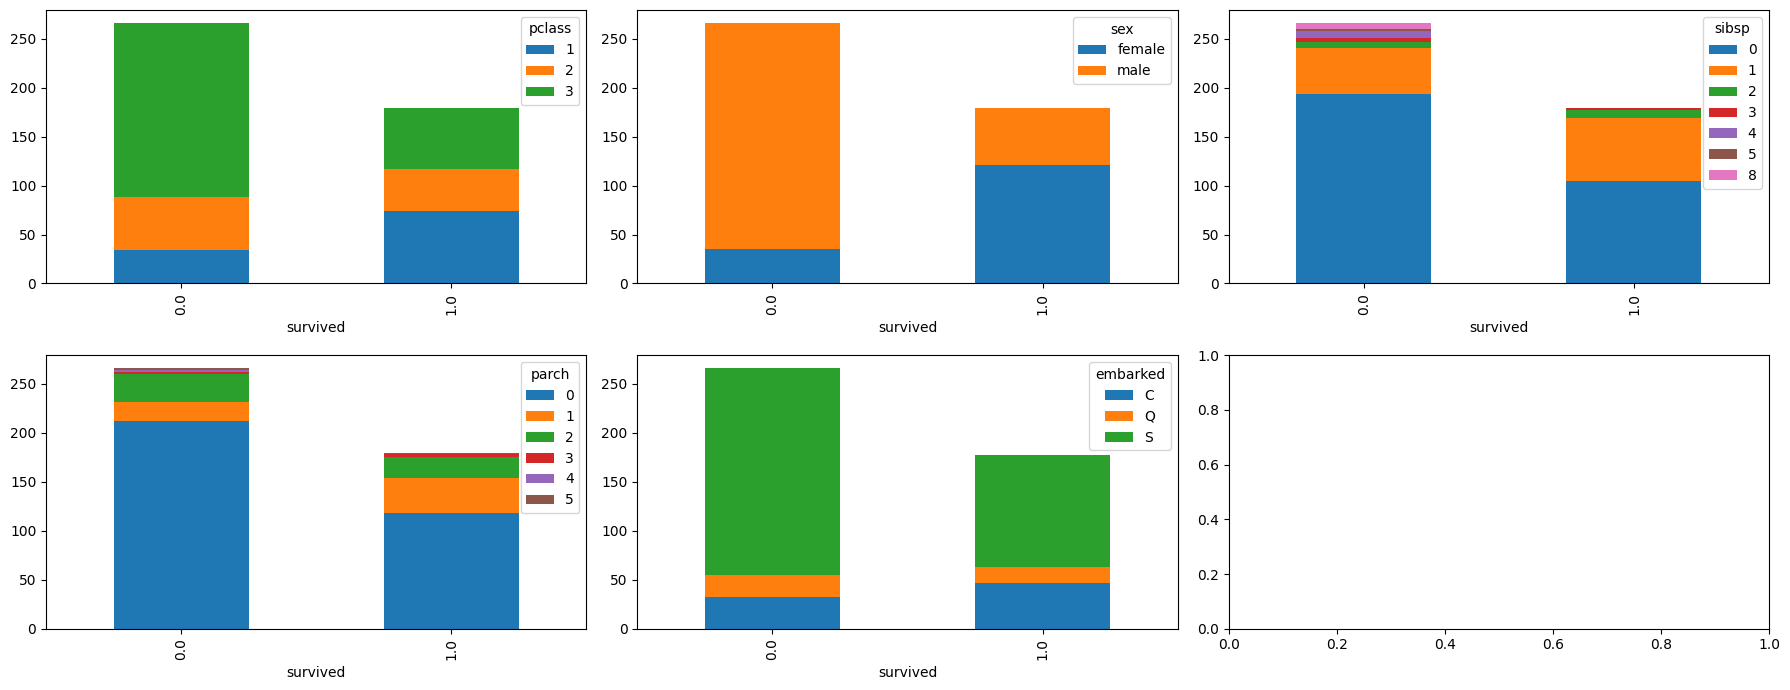

In [631]:
#データの可視化
#回帰問題なら、カテゴリ変数はカテゴリごとに箱ひげ図、連続変数は、散布図
#分類問題なら目的変数のクラスごとに、カテゴリ変数は積み上げ棒グラフ、連続変数はKDE
fig, axes = plt.subplots(2,3, figsize=(18,7))
axes=axes.flatten()
df_gra={}
cate_colums =  ["pclass","sex","sibsp","parch", "embarked"]
for i, col in enumerate(cate_colums):
    df_gra[col] = df_all.groupby(["survived",col]).size().unstack() #最初が行(ｘ側)になる
    df_gra[col].plot(kind="bar",stacked=True, ax=axes[i])
# レイアウト調整
plt.tight_layout()
plt.show()

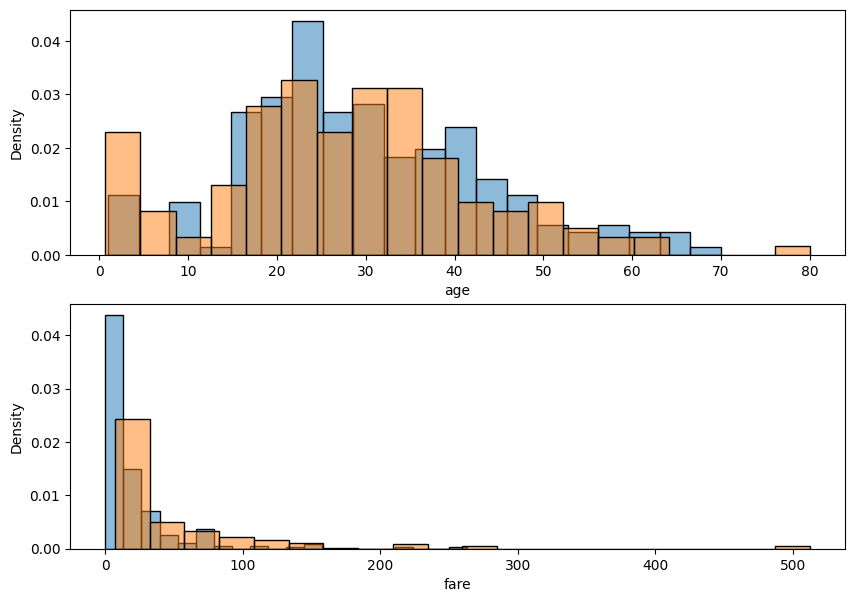

In [632]:
num_colums = ["age", "fare"]
fig, axes = plt.subplots(2,1, figsize=(10,7))
axes=axes.flatten()
df_gra={}
for i, col in enumerate(num_colums):
    sns.histplot(df_all[df_all["survived"]==0][col], label="y=0",
                stat="density",bins=20, alpha=0.5, ax=axes[i],)
    sns.histplot(df_all[df_all["survived"]==1][col], label="y=1",
                stat="density",bins=20,alpha=0.5, ax=axes[i])
plt.show()

In [633]:
#欠損値処理の処理
#fillnaを実行しただけだと元のデータは変わらないので代入する
df_all["age"] = df_all["age"].fillna(df_all["age"].mean())
df_all["embarked"] = df_all["embarked"].fillna(df_all["embarked"].mode()[0])
#mode()は最頻値が複数あるときのためにシリーズ型(可変のインデックスを持つリスト)を返すので[0]で先頭を選択
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 0 to 445
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        891 non-null    int64  
 1   survived  445 non-null    float64
 2   pclass    891 non-null    int64  
 3   sex       891 non-null    object 
 4   age       891 non-null    float64
 5   sibsp     891 non-null    int64  
 6   parch     891 non-null    int64  
 7   fare      891 non-null    float64
 8   embarked  891 non-null    object 
 9   ds_test   891 non-null    int64  
dtypes: float64(3), int64(5), object(2)
memory usage: 76.6+ KB


In [634]:
#ダミー化
# pd.get_dummies(data=df_all) これでもOK
df_all["embarked"], uniques_em = pd.factorize(df_all["embarked"])
df_all["sex"], uniques_s = pd.factorize(df_all["sex"])
print (df_all.head(), "\n",
       uniques_em, uniques_s)

   id  survived  pclass  sex   age  sibsp  parch     fare  embarked  ds_test
0   3       1.0       1    0  35.0      1      0  53.1000         0        0
1   4       0.0       3    1  35.0      0      0   8.0500         0        0
2   7       0.0       3    1   2.0      3      1  21.0750         0        0
3   9       1.0       2    0  14.0      1      0  30.0708         1        0
4  11       1.0       1    0  58.0      0      0  26.5500         0        0 
 Index(['S', 'C', 'Q'], dtype='object') Index(['female', 'male'], dtype='object')


次元削減、クラスタリング、パターンの発見→教師なし学習
予測(回帰、分類)→教師あり学習
動的で複雑な選択の最適解を求める→強化学習

In [635]:
#今回は教師あり学習の中の勾配ブースティングモデルを使う
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [636]:
df_train = df_all[df_all["ds_test"]==0]
df_test = df_all[df_all["ds_test"]==1]
X = df_train[["pclass","sex","age", "fare"]]
y = df_train["survived"]

In [637]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [638]:
model=GradientBoostingClassifier(random_state=44)
model.fit(X_train ,y_train)

GradientBoostingClassifier(random_state=44)

In [639]:
y_train_pred = model.predict(X_train)

In [640]:

y_train_pred = model.predict(X_train)
cr = classification_report(y_train, y_train_pred, output_dict=True)
pd.DataFrame(cr)


,0.0,1.0,accuracy,macro avg,weighted avg
precision,0.899563,0.968504,0.924157,0.934034,0.927837
recall,0.980952,0.842466,0.924157,0.911709,0.924157
f1-score,0.938497,0.901099,0.924157,0.919798,0.923159
support,210.000000,146.000000,0.924157,356.000000,356.000000


In [641]:
y_test_pred = model.predict(X_test)
cr = classification_report(y_test, y_test_pred, output_dict=True)
pd.DataFrame(cr)

,0.0,1.0,accuracy,macro avg,weighted avg
precision,0.836066,0.821429,0.831461,0.828747,0.830638
recall,0.910714,0.696970,0.831461,0.803842,0.831461
f1-score,0.871795,0.754098,0.831461,0.812947,0.828155
support,56.000000,33.000000,0.831461,89.000000,89.000000


In [642]:
#提出
test = df_test[["pclass","sex","age", "fare"]]
pred = model.predict_proba(test)[:, 1] 
sample_submit = pd.DataFrame()
sample_submit[0] = test.index
sample_submit[1] = pred
sample_submit.to_csv('submit3.tsv', header=None, sep='\t', index=False)
